Mount my google drive, where I stored the dataset.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Download dependencies**

In [0]:
!pip3 install sklearn matplotlib GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=97d8664f287fd6b5b5b6c0d2cf26a8bfa078606a4d79f040e039c2efc8899d1f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [0]:
!pip3 install "pillow<7"

     |████████████████████████████████| 2.1MB 10.6MB/s eta 0:00:01


In [0]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 621.4MB 35kB/s  eta 0:00:0111s eta 0:20:2744.8MB 125.4MB/s eta 0:00:05| 74.8MB 4.4MB/s eta 0:02:05 |██████                          | 115.2MB 4.4MB/s eta 0:01:56     |███████▏                        | 139.0MB 91.9MB/s eta 0:00:06��████▏                     | 198.1MB 30.0MB/s eta 0:00:15     |██████████▋                     | 205.4MB 30.0MB/s eta 0:00:14��█████                     | 215.5MB 30.0MB/s eta 0:00:14MB/s eta 0:00:15/s eta 0:00:15██▉                   | 249.1MB 26.9MB/s eta 0:00:14     |███████████████▎                | 297.3MB 52.2MB/s eta 0:00:07�███████████                | 310.5MB 52.2MB/s eta 0:00:06     |█████████████████               | 331.5MB 22.0MB/s eta 0:00:14��██              | 350.1MB 22.0MB/s eta 0:00:13     |██████████████████▍             | 358.1MB 22.0MB/s eta 0:00:12     |███████████████████▍            | 376.2MB 116.7MB/s eta 0:00:032MB 116.7MB/s eta

**Download Data**

In order to acquire the dataset please navigate to:

https://ieee-dataport.org/documents/cervigram-image-dataset

Unzip the dataset into the folder "dataset".

For your environment, please adjust the paths accordingly.

In [0]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

Archive:  dataset/cervigram-image-dataset-v2.zip
   creating: dataset/data/
   creating: dataset/data/test/
   creating: dataset/data/test/0/
   creating: dataset/data/test/0/20151103002/
  inflating: dataset/data/test/0/20151103002/20151103113458.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113637.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113659.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113722.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113752.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113755.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113833.jpg  
   creating: dataset/data/test/0/20151103005/
  inflating: dataset/data/test/0/20151103005/20151103161719.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161836.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161908.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161938.jpg  
  inflating: dataset/data/test/0/2015110

**Constants**

For your environment, please modify the paths accordingly.  

In [0]:
TRAIN_PATH = '/content/dataset/data/train/'
TEST_PATH = '/content/dataset/data/test/'
# TRAIN_PATH = 'dataset/data/train/'
# TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 150

# prefix = ''
prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
CHACKPOINT_SIMPLE_MODEL = prefix + 'Cancer Detection MobileNetV2 All Natural Images Full Conv32-0.7 6 Dec.tar'

**Imports**

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import GPUtil
import math

**Memory Stats**

In [0]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


**Deterministic Measurements**

This statements help making the experiments reproducible by fixing the random seeds. Despite fixing the random seeds, experiments are usually not reproducible using different PyTorch releases, commits, platforms or between CPU and GPU executions. Please find more details in the PyTorch documentation:

https://pytorch.org/docs/stable/notes/randomness.html

In [0]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Loading Data**

The dataset is structured in multiple small folders of 7 images each. This generator iterates through the folders and returns the category and 7 paths: one for each image in the folder. The paths are ordered; the order is important since each folder contains 3 types of images, first 5 are with acetic acid solution and the last two are through a green lens and having iodine solution(a solution of a dark red color).

In [0]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which load 3 kinds of images: natural images, images taken through a green lens and images where the doctor applied iodine solution (which gives a dark red color). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data. 

In [0]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [0]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [0]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [0]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the effects of the data augmentation on the training set.

In [0]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [0]:
# x, y = next(iter(loader_train_simple_img))
# plot_predictions(x, y, y)

**Model**

Define a few models to experiment with.

In [0]:
def get_mobilenet_v2():
  model = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
  # model.classifier[0] = t.nn.Dropout(p=0.9, inplace=False)
  # model.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  # model.features[18].add_module('cnn_drop_18', t.nn.Dropout2d(p = .3))
  # model.features[17]._modules['conv'][1].add_module('cnn_drop_17', t.nn.Dropout2d(p = .2))
  # model.features[16]._modules['conv'][1].add_module('cnn_drop_16', t.nn.Dropout2d(p = .1))
  model = model.cuda()
  return model

def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[2].p = .2
  model.classifier[6].out_features = 4
  return model

def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=2048, out_features=4)
  )
  model = model.cuda()
  return model

def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=512, out_features=4)
  )
  model = model.cuda()
  return model

def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features = 1024, out_features = 4)
  )
  model = model.cuda()
  return model

class MobileNetV2_FullConv(t.nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = get_mobilenet_v2().features
    self.cnn[18] = t.nn.Sequential(
      tv.models.mobilenet.ConvBNReLU(320, 32, kernel_size=1),
      t.nn.Dropout2d(p = .7)
    )
    # self.fc = t.nn.Sequential(
      # t.nn.Flatten(),
      # t.nn.Dropout(0.4),
      # t.nn.Linear(8 * 7 * 10, 4),
    # )
    self.fc = t.nn.Linear(32, 4)

  def forward(self, x):
    x = self.cnn(x)
    x = x.mean([2, 3])
    x = self.fc(x);
    return x

In [0]:
model_simple = t.nn.DataParallel(MobileNetV2_FullConv().cuda())

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 36.2MB/s]


**Train & Evaluate**

Timer utility function. This is used to measure the execution speed.

In [0]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and evaluates it at the same time. It outputs the metrics recorded during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is improved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [0]:
import statistics

In [0]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': [],

      'mean_class_acc_train': [],
      'mean_class_acc_test': []  
  }

  best_mean_acc = 0
  
  loss_weights = t.tensor([1/4] * 4, device='cuda:0')
    
  try:  
    for epoch in range(epochs):
      timer_start()
      loss_fn = t.nn.CrossEntropyLoss(weight = loss_weights)
      # loss_fn = t.nn.CrossEntropyLoss()
      # loss_fn = FocalLoss(gamma = 2)
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      conf_matrix = np.zeros((4, 4))
      for x, y in loader_train:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
        conf_matrix += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      mean_class_acc = statistics.harmonic_mean(class_acc)
      errors = [1 - conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      errors_strong = [math.exp(100 * e) for e in errors]
      loss_weights = t.tensor([e / sum(errors_strong) for e in errors_strong], device = 'cuda:0')
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
      metrics['mean_class_acc_train'].append(mean_class_acc) 

      # Evaluate
      model.eval()
      with t.no_grad():
        conf_matrix_test = np.zeros((4, 4))
        for x, y in loader_test:
          y_pred = model.forward(x)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
          conf_matrix_test += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
        class_acc_test = [conf_matrix_test[i][i] / sum(conf_matrix_test[i]) for i in range(len(conf_matrix_test))]
        mean_class_acc_test = statistics.harmonic_mean(class_acc_test)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
        metrics['mean_class_acc_test'].append(mean_class_acc_test) 
      
      if metrics['mean_class_acc_test'][-1] > best_mean_acc:
        best_mean_acc = metrics['mean_class_acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} mean class acc {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['mean_class_acc_test'][-1], metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [0]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

In [0]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [0]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['mean_class_acc_test']).argmax()
    print('Best mean class accuracy :', metrics['mean_class_acc_test'][index_max])
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['mean_class_acc_train'], metrics['mean_class_acc_test'], 'Mean Class Accuracy (lr = {})'.format(learn_rate), 'Mean Class Accuracy')
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

Perform actual training

In [0]:
def calculate_class_acc_for_test_set(model):
  model.eval()
  with t.no_grad():
    conf_matrix = np.zeros((4, 4))
    for x, y in loader_test_simple_img:
      y_pred = model.forward(x)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      cm = sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      conf_matrix += cm
    print('Confusion matrix:\n', conf_matrix)
    class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
    print('Class acc:\n', class_acc)
    mean_class_acc = statistics.harmonic_mean(class_acc)
    print('Mean class accuracy:\n', mean_class_acc)
    return class_acc

def plot_class_acc(class_acc):
  plt.bar(list(range(4)), class_acc, align='center', alpha=0.5)
  plt.xticks(list(range(4)), list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('Accuracy')
  plt.savefig('AccPerClass.pdf', dpi = 300, format = 'pdf')
  plt.show()

def plot_class_acc_comparison(class_acc_1, class_acc_2, title_1, title_2):
  width = .3
  plt.bar(list(range(4)), class_acc_1, width, alpha=0.5, color = 'green', label = title_1)
  plt.bar(np.array(list(range(4))) + width, class_acc_2, width, alpha=0.5, color = 'blue', label = title_2)
  plt.xticks(np.array(list(range(4))) + width/2, list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig('ClassAccCompare.pdf', dpi = 300, format = 'pdf')
  plt.show()

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


Confusion matrix:
 [[55.  0.  4.  1.]
 [30. 25.  5.  0.]
 [17.  1. 39.  3.]
 [ 1.  1.  6. 52.]]
Class acc:
 [0.9166666666666666, 0.4166666666666667, 0.65, 0.8666666666666667]
Mean class accuracy:
 0.6469124632436101


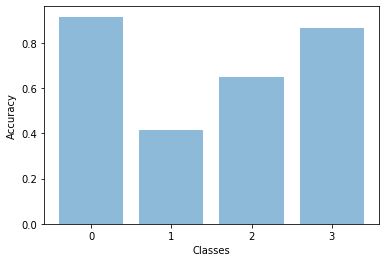

In [0]:
model = MobileNetV2_FullConv().cuda()
checkpoint = t.load(CHACKPOINT_SIMPLE_MODEL)
model.load_state_dict(checkpoint['model'])
class_acc = calculate_class_acc_for_test_set(model)
plot_class_acc(class_acc)

Text(0, 0.5, 'Image count')

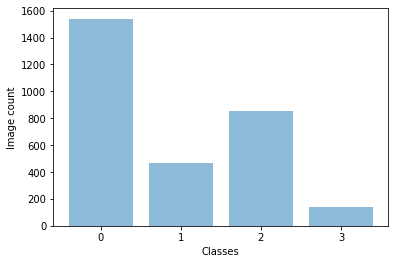

In [0]:
trainig_data_count = [1540 , 469, 854 , 140 ]
trainig_data_distirbution = [t / sum(trainig_data_count) for t in trainig_data_count]
plt.bar(list(range(4)), trainig_data_count, align='center', alpha=0.5)
plt.xticks(list(range(4)), list(range(4)))
plt.xlabel('Classes')
plt.ylabel('Image count')
# plt.savefig('TrainingDataDistribution.pdf', dpi = 300, format = 'pdf')
# plt.show()